In [1]:
# Setup
from mlwpy import *
%matplotlib inline

diabetes = datasets.load_diabetes()
tts = skms.train_test_split(diabetes.data, 
diabetes.target, test_size=.25, random_state=42)


(diabetes_train_ftrs, diabetes_test_ftrs,
diabetes_train_tgt,
diabetes_test_tgt) = tts

In [2]:
baseline = dummy.DummyRegressor(strategy='median')

In [3]:
strategies = ['constant', 'quantile', 'mean', 'median', ]
baseline_args = [{"strategy":s} for s in strategies]
# additional args for constant and quantile
baseline_args[0]['constant'] = 50.0
baseline_args[1]['quantile'] = 0.75

# similar to ch 5, but using a list comprehension
# process a single argument package (a dict)

def do_one(**args):
    baseline = dummy.DummyRegressor(**args)
    baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
    base_preds = baseline.predict(diabetes_test_ftrs)
    return metrics.mean_squared_error(base_preds, diabetes_test_tgt)

# gather all results via a list comprehension
mses = [do_one(**bla) for bla in baseline_args]

display(pd.DataFrame({'mse':mses}, index=strategies))

,mse
constant,"14,657.6847"
quantile,"10,216.3874"
mean,"5,607.1979"
median,"5,542.2252"


In [4]:
def rms_error(actual, predicted):
    ' root-mean-squared-error function '
    # lesser values are better (a < b means a is better)
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)

def neg_rmse_score(actual, predicted):
    ' rmse based score function '
    # greater values are better (a < b means b better)
    return -rms_error(actual, predicted)

def neg_rmse_scorer(mod, ftrs, tgt_actual):
    ' rmse scorer suitable for scoring arg '
    tgt_pred = mod.predict(ftrs)
    return neg_rmse_score(tgt_actual, tgt_pred)

knn = neighbors.KNeighborsRegressor(n_neighbors=3)
skms.cross_val_score(knn,
    diabetes.data, diabetes.target,
    cv=skms.KFold(5, shuffle=True),
    scoring=neg_rmse_scorer)

array([-58.0034, -64.9886, -63.1431, -61.8124, -57.6243])

In [5]:
lr = linear_model.LinearRegression()
# help(lr.score) # for full output
print(lr.score.__doc__.splitlines()[0])

Return the coefficient of determination of the prediction.


In [7]:
our_preds = np.array([1, 2, 3])
mean_preds = np.array([2, 2, 2])
actual = np.array([2, 3, 4])
sse_ours = np.sum(( our_preds - actual)**2)
sse_mean = np.sum((mean_preds - actual)**2)

In [8]:
r_2 = 1 - (sse_ours / sse_mean)
print("manual r2:{:5.2f}".format(r_2))

manual r2: 0.40


In [ ]:
baseline = dummy.DummyRegressor(strategy='mean')

baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
base_preds = baseline.predict(diabetes_test_ftrs)

# r2 is not symmetric because true values have priority
# and are used to compute target mean
base_r2_sklearn = metrics.r2_score(diabetes_test_tgt, base_preds)
print(base_r2_sklearn)

-0.014016723490579253


In [ ]:
# sklearn-train-mean to predict test tgts
base_errors = base_preds - diabetes_test_tgt
sse_base_preds = np.dot(base_errors, base_errors)

# train-mean to predict test targets
train_mean_errors = np.mean(diabetes_train_tgt) - diabetes_test_tgt
sse_mean_train = np.dot(train_mean_errors, train_mean_errors)

# test-mean to predict test targets (Danger Will Robinson!)
test_mean_errors = np.mean(diabetes_test_tgt) - diabetes_test_tgt
sse_mean_test = np.dot(test_mean_errors, test_mean_errors)

print("sklearn train-mean model SSE(on test):", sse_base_preds)
print(" manual train-mean model SSE(on test):", sse_mean_train)
print(" manual test-mean model SSE(on test):", sse_mean_test)

sklearn train-mean model SSE(on test): 622398.970317905
 manual train-mean model SSE(on test): 622398.970317905
 manual test-mean model SSE(on test): 613795.5675675675


In [12]:
1 - (sse_base_preds / sse_mean_test)

-0.014016723490578809

In [13]:
print(base_r2_sklearn)
print(1 - (sse_base_preds / sse_mean_test))

-0.014016723490579253
-0.014016723490578809


In [14]:
#
# WARNING! Don't try this at home, boys and girls!
# We are fitting on the *test* set... to mimic the behavior
# of sklearn R^2.
#
testbase = dummy.DummyRegressor(strategy='mean')
testbase.fit(diabetes_test_ftrs, diabetes_test_tgt)
testbase_preds = testbase.predict(diabetes_test_ftrs)
testbase_mse = metrics.mean_squared_error(testbase_preds,
diabetes_test_tgt)

models = [neighbors.KNeighborsRegressor(n_neighbors=3),
linear_model.LinearRegression()]
results = co.defaultdict(dict)
for m in models:
    preds = (m.fit(diabetes_train_ftrs, diabetes_train_tgt)
              .predict(diabetes_test_ftrs))
    mse = metrics.mean_squared_error(preds, diabetes_test_tgt)
    r2 = metrics.r2_score(diabetes_test_tgt, preds)
    results[get_model_name(m)]['R^2'] = r2
    results[get_model_name(m)]['MSE'] = mse
    
print(testbase_mse)
df = pd.DataFrame(results).T
df['Norm_MSE'] = df['MSE'] / testbase_mse
df['1-R^2'] = 1-df['R^2']
display(df)

5529.689797906013


,R^2,MSE,Norm_MSE,1-R^2
KNeighborsRegressor,0.3722,"3,471.4194",0.6278,0.6278
LinearRegression,0.4849,"2,848.3107",0.5151,0.5151


In [15]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                      'actual': [3, 5, 7]})
ape_df['error'] = ape_df['predicted'] - ape_df['actual']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error
example,,,
0,4,3,1
1,2,5,-3
2,9,7,2


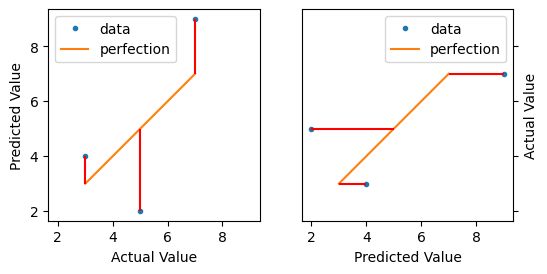

In [17]:
def regression_errors(figsize, predicted, actual, errors='all'):
    ''' figsize -> subplots;
        predicted/actual data -> columns in a DataFrame
        errors -> "all" or sequence of indices '''
    fig, axes = plt.subplots(1, 2, figsize=figsize,
      sharex=True, sharey=True)

    df = pd.DataFrame({'actual':actual,
                    'predicted':predicted})

    for ax, (x,y) in zip(axes, it.permutations(['actual',
    'predicted'])):
        # plot the data as '.'; perfect as y=x line
        ax.plot(df[x], df[y], '.', label='data')
        ax.plot(df['actual'], df['actual'], '-',
                label='perfection')
        ax.legend()
        ax.set_xlabel('{} Value'.format(x.capitalize()))
        ax.set_ylabel('{} Value'.format(y.capitalize()))
        ax.set_aspect('equal')
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")

    # show connecting bars from data to perfect
    # for all or only those specified?
    if errors == 'all':
        errors = range(len(df))
    if errors:
        acts = df.actual.iloc[errors]
        preds = df.predicted.iloc[errors]
        axes[0].vlines(acts, preds, acts, 'r')
        axes[1].hlines(acts, preds, acts, 'r')

regression_errors((6, 3), ape_df.predicted, ape_df.actual)

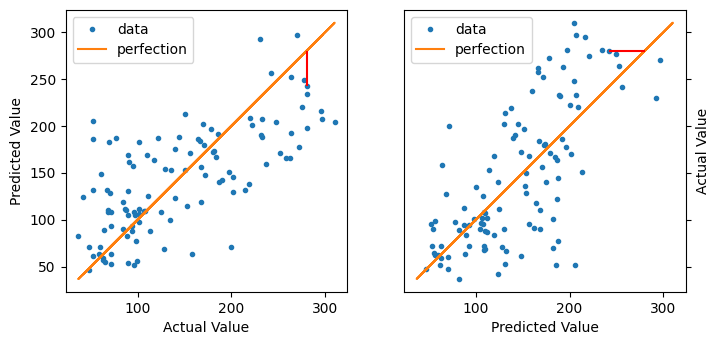

In [ ]:
lr = linear_model.LinearRegression()
preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
        .predict(diabetes_test_ftrs))
regression_errors((8, 4), preds, diabetes_test_tgt, errors=[-20])

In [ ]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                      'actual': [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']
ape_df['resid'] = ape_df['actual'] - ape_df['predicted']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error,resid
example,,,,
0,4,3,1,-1
1,2,5,-3,3
2,9,7,2,-2


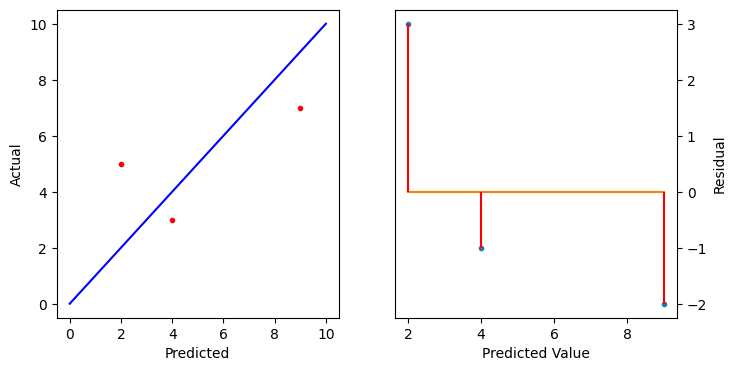

In [20]:
def regression_residuals(ax, predicted, actual,
                        show_errors=None, right=False):
      ''' figsize -> subplots;
      predicted/actual data -> columns of a DataFrame
      errors -> "all" or sequence of indices '''
      df = pd.DataFrame({'actual':actual,
                        'predicted':predicted})
      df['error'] = df.actual - df.predicted
      ax.plot(df.predicted, df.error, '.')
      ax.plot(df.predicted, np.zeros_like(predicted), '-')

      if right:
          ax.yaxis.tick_right()
          ax.yaxis.set_label_position("right")
          ax.set_xlabel('Predicted Value')
          ax.set_ylabel('Residual')

      if show_errors == 'all':
          show_errors = range(len(df))
      if show_errors:
          preds = df.predicted.iloc[show_errors]
          errors = df.error.iloc[show_errors]
          ax.vlines(preds, 0, errors, 'r')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.plot(ape_df.predicted, ape_df.actual, 'r.',
          [0, 10], [0, 10], 'b-')

ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
regression_residuals(ax2, ape_df.predicted, ape_df.actual,
'all', right=True)

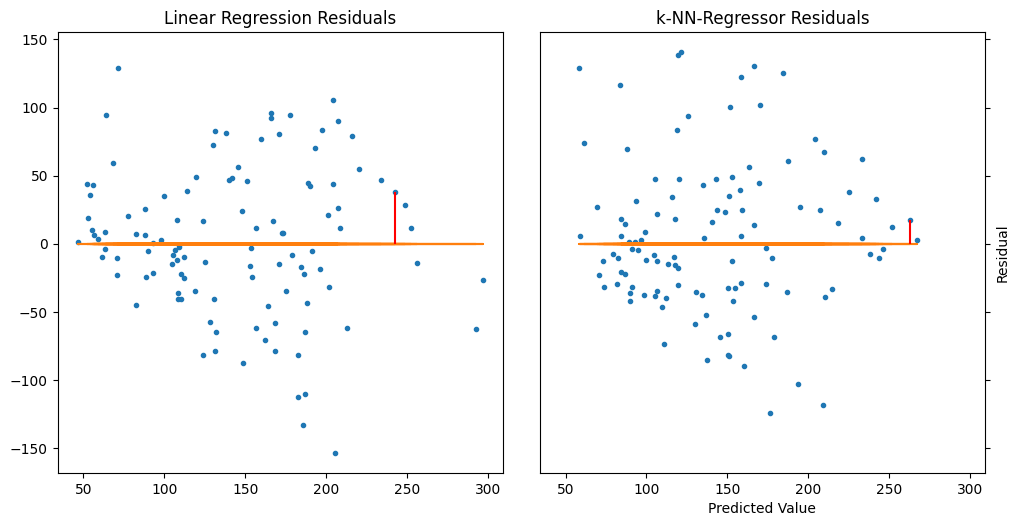

In [21]:
lr = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor()

models = [lr, knn]

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                        sharex=True, sharey=True)
fig.tight_layout()
for model, ax, on_right in zip(models, axes, [False, True]):
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
            .predict(diabetes_test_ftrs))
    regression_residuals(ax, preds, diabetes_test_tgt, [-20], on_right)

axes[0].set_title('Linear Regression Residuals')
axes[1].set_title('k-NN-Regressor Residuals');